# Tamil Nadu SIR Draft Voter Roll Impact Analysis

### Objective

The goal is to evaluate whether **voter roll revisions under Tamil Nadu SIR (2025)** are large enough to **numerically affect election outcomes**, using **victory margin** from the 2021 Assembly Election as the sensitivity threshold.

> This is a **data-driven impact analysis**, not an allegation-based study.


## Tamil Nadu Total Voters Count

SIR - Special Intensive Revision <br/>
SSR - Special Summary Revision

### Key Numbers

2021 Assembly Electoral Roll: **6,29,43,512 crore voters** <br/>
SSR 2025 (as on 06-01-2025, before SIR): **6,36,12,950 crore voters** <br/>
After SIR Draft Roll: **5,43,76,756 crore voters**


### What Changed

After SIR 2025: **97,37,831 lakh** voters deleted  


### One-Line Takeaway

The **SIR 2025 exercise removed 97,37,831 lakh voters**, bringing Tamil Nadu’s electorate down from **6.36 crore to 5.43 crore**, a **net drop of ~0.97 crore**.


Sources

https://en.wikipedia.org/wiki/2021_Tamil_Nadu_Legislative_Assembly_election <br/>
https://www.elections.tn.gov.in/ACwise_Gendercount_06012025.aspx  <br/>
https://www.elections.tn.gov.in/ACwise_Gendercount_19122025.aspx

## Analytical Framework

This analysis is based on three simple ideas:

1. **Victory Margin (2021)**  
   - The number of votes that decided the election result.

2. **Not Voted (2021)**  
   - Registered voters who did not vote, used as a baseline for comparison.

3. **Removed Voters (2025)**  
   - Changes in the voter roll after the SIR revision.
### Core Question
> Are voter roll changes large enough to be considered significant when compared to the margin that decided the election?


In [5]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("../db/tn_election.db")

## Load Curated Tables

The following pre-processed tables are loaded from SQLite:

- `election_results_2021` → victory margin & parties  
- `voters_2021` → turnout & not voted baseline  
- `voters_2025` → revised voter roll (SIR 2025)


In [6]:
df_results_2021 = pd.read_sql("SELECT * FROM election_results_2021", conn)

df_voters_2021 = pd.read_sql("SELECT * FROM voters_2021", conn)

df_voters_2025 = pd.read_sql("SELECT * FROM voters_2025", conn)

## Compare Voter Rolls (2021 vs 2025)


In [7]:
df_roll_compare = (
    df_voters_2021
    .merge(
        df_voters_2025,
        on=["ac_no", "ac_name"],
        how="inner"
    )
)

df_roll_compare["removed_voters_2025"] = (
    df_roll_compare["total_eligible_voters_2021"]
    - df_roll_compare["total_eligible_voters_2025"]
)

df_roll_compare.head()

,ac_no,ac_name,total_votes_polled_2021,total_eligible_voters_2021,not_voted_2021,total_eligible_voters_2025,removed_voters_2025
0,1,Gummidipoondi,222069,281688,59619,242558,39130
1,2,Ponneri,210354,267368,57014,239141,28227
2,3,Tiruttani,232624,291336,58712,252154,39182
3,4,Thiruvallur,214243,274982,60739,238818,36164
4,5,Poonamallee,263736,358218,94482,348034,10184


## Attach Election Outcome Data

Victory margin from the 2021 election is now joined with
voter roll changes to assess **outcome sensitivity**.

In [8]:
df_analysis = (
    df_results_2021
    .merge(
        df_roll_compare,
        on=["ac_no", "ac_name"],
        how="inner"
    )
)

df_analysis.head()

,ac_no,ac_name,winner_party,votes_winner,runnerup_party,votes_runnerup,victory_margin,total_votes_polled_2021,total_eligible_voters_2021,not_voted_2021,total_eligible_voters_2025,removed_voters_2025
0,1,Gummidipoondi,DMK,126452,PMK,75514,50938,222069,281688,59619,242558,39130
1,2,Ponneri,INC,94528,ADMK,84839,9689,210354,267368,57014,239141,28227
2,3,Tiruttani,DMK,120314,ADMK,91061,29253,232624,291336,58712,252154,39182
3,4,Thiruvallur,DMK,107709,ADMK,85008,22701,214243,274982,60739,238818,36164
4,5,Poonamallee,DMK,149578,PMK,55468,94110,263736,358218,94482,348034,10184


## Core Impact Tests

Two key comparisons are performed:

1. **Removed Voters vs Victory Margin**
   - Determines if roll changes exceed the threshold that decided the election.

2. **Removed Voters vs Not Voted (2021)**
   - Provides historical inactivity context.

In [9]:
df_analysis["removed_gt_margin"] = (
    df_analysis["removed_voters_2025"] > df_analysis["victory_margin"]
)

df_analysis["removed_gt_not_voted"] = (
    df_analysis["removed_voters_2025"] > df_analysis["not_voted_2021"]
)

## Risk Classification

Each constituency is classified based on the magnitude of
voter roll change relative to:

- victory margin
- historical non-participation

This creates a **numerical risk categorization**, not a judgement.


### Risk Level Explanation

- **Low Impact**  
  Removed voters are smaller than the victory margin.  
  → Roll changes are unlikely to affect the result.

- **Moderate Impact**  
  Removed voters exceed past non-voters but not the victory margin.  
  → Changes are noticeable but still below the outcome threshold.

- **High Impact**  
  Removed voters are greater than the victory margin.  
  → The constituency becomes sensitive, and the result could potentially change.

- **Critical Impact**  
  Removed voters exceed both the victory margin and historical non-voters.  
  → Highest sensitivity, where roll changes are large enough to matter significantly.

- **No Removal / Increase**  
  Voter count increased or remained stable.  
  → No risk from voter roll changes.


In [10]:
def classify_risk(row):
    if row["removed_voters_2025"] <= 0:
        return "No Removal / Increase"
    if row["removed_gt_margin"] and row["removed_gt_not_voted"]:
        return "Critical Impact"
    if row["removed_gt_margin"]:
        return "High Impact"
    if row["removed_gt_not_voted"]:
        return "Moderate Impact"
    return "Low Impact"

df_analysis["risk_level"] = df_analysis.apply(classify_risk, axis=1)

## Final Analytical Dataset

This table represents the **final output** of the project
and is used for reporting, visualization, and SQL storage.


In [19]:
df_final_analysis = df_analysis[
    [
        "ac_no",
        "ac_name",
        "winner_party",
        "runnerup_party",
        "victory_margin",
        "total_eligible_voters_2021",
        "total_eligible_voters_2025",
        "removed_voters_2025",
        "not_voted_2021",
        "risk_level"
    ]
].sort_values(
    "removed_voters_2025",
    ascending=False
)

df_final_analysis.head()

,ac_no,ac_name,winner_party,runnerup_party,victory_margin,total_eligible_voters_2021,total_eligible_voters_2025,removed_voters_2025,not_voted_2021,risk_level
26,27,Shozhinganallur,DMK,ADMK,35405,698893,484011,214882,310538,High Impact
29,30,Pallavaram,DMK,ADMK,37783,436239,294712,141527,170049,High Impact
6,7,Maduravoyal,DMK,ADMK,31721,452195,325407,126788,178325,High Impact
25,26,Velachery,INC,ADMK,4352,314578,189999,124579,137864,High Impact
20,21,Anna Nagar,DMK,ADMK,27445,286090,162135,123955,120994,Critical Impact


## Key Insights

- Constituencies where **removed voters exceed victory margin**
  are numerically sensitive to roll revisions.

- Comparing removals with **not voted (2021)** prevents misleading conclusions.

- The analysis highlights **outcome sensitivity**, not intent.


In [12]:
df_final_analysis.to_sql(
    "voter_roll_impact_analysis",
    conn,
    if_exists="replace",
    index=False
)

232

## Visual Impact Analysis

In [13]:
import matplotlib.pyplot as plt
import numpy as np

### Victory Margin vs Removed Voters (Core Sensitivity Plot)

This scatter plot visualizes whether voter roll changes
exceed the margin that decided the 2021 election.

- X-axis: Victory Margin (2021)
- Y-axis: Removed Voters (2025)
- Points above the horizontal axis indicate voter removal

Constituencies where removed voters exceed the victory margin
are numerically sensitive to roll revisions.


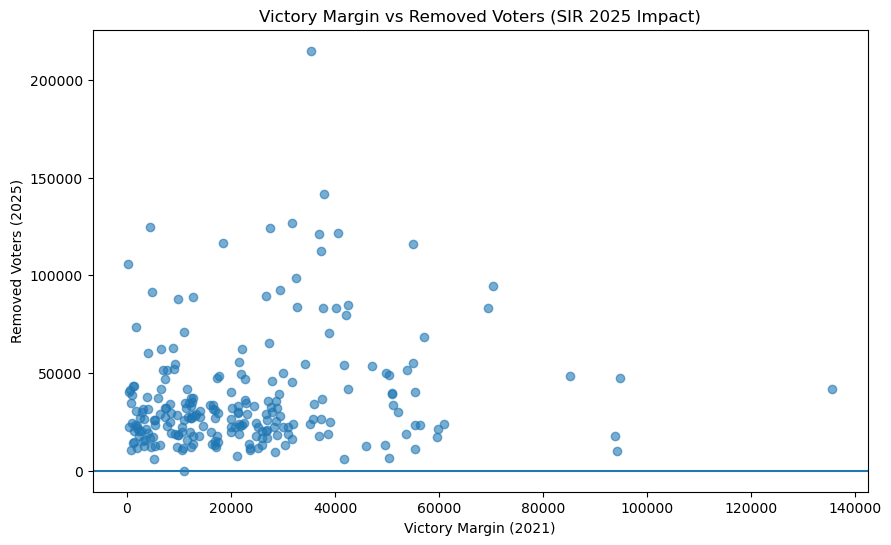

In [14]:
plt.figure(figsize=(10, 6))

plt.scatter(
    df_final_analysis["victory_margin"],
    df_final_analysis["removed_voters_2025"],
    alpha=0.6
)

plt.axhline(y=0)
plt.xlabel("Victory Margin (2021)")
plt.ylabel("Removed Voters (2025)")
plt.title("Victory Margin vs Removed Voters (SIR 2025 Impact)")

plt.show()

### How to read the chart

- Points above the zero line indicate constituencies where voters were removed

- Further right → constituency was won by a larger margin in 2021

- Higher up → larger voter roll reduction in 202

### Direct Takeaway from the above chart

**Key observation:**  
> In many constituencies, the number of voters removed is higher than the margin that decided the election.

**What this means:**  
> When more voters are removed than the victory margin, the result could potentially change, especially since the total number of voters did not increase significantly from 2021 to 2025 to balance these removals.


### High-Impact Constituencies: Removed Voters vs Victory Margin

This clustered bar chart compares
removed voters and victory margins **side-by-side**
for constituencies classified as high or critical impact.

This visualization clearly shows where voter roll changes
exceed the threshold that decided the election.

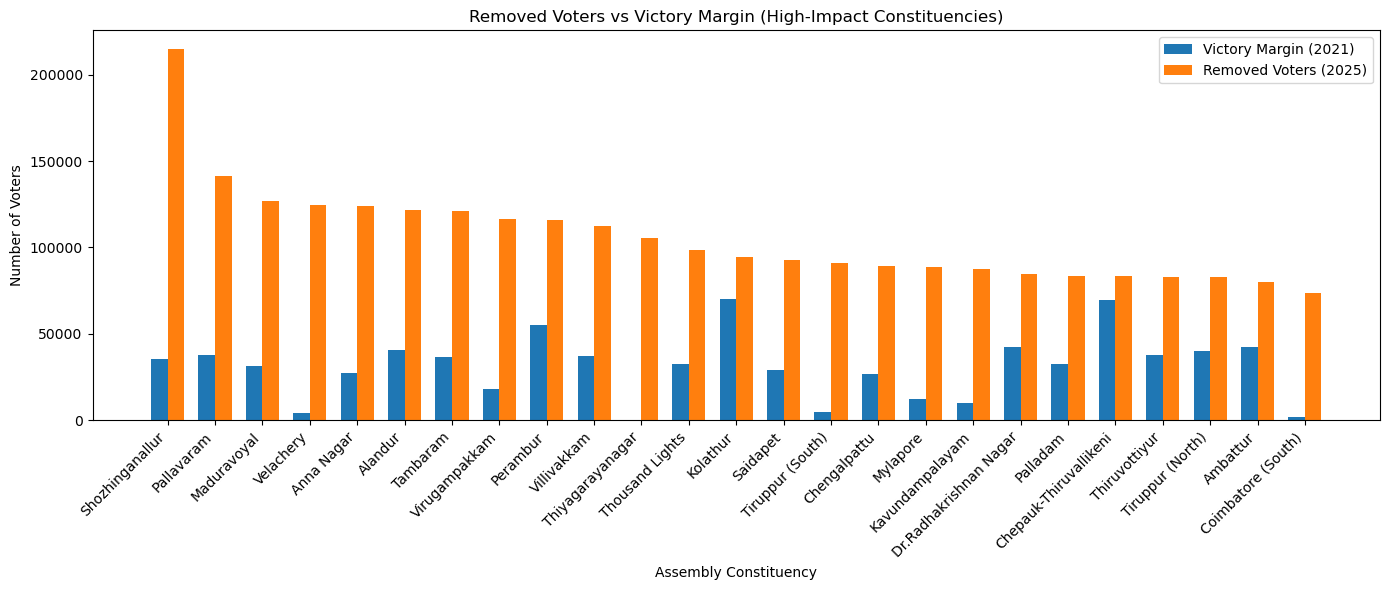

In [15]:
high_impact = df_final_analysis[
    df_final_analysis["risk_level"].isin(
        ["High Impact", "Critical Impact"]
    )
].sort_values(
    "removed_voters_2025",
    ascending=False
).head(25)

x = np.arange(len(high_impact))
width = 0.35

plt.figure(figsize=(14, 6))

plt.bar(
    x - width/2,
    high_impact["victory_margin"],
    width,
    label="Victory Margin (2021)"
)

plt.bar(
    x + width/2,
    high_impact["removed_voters_2025"],
    width,
    label="Removed Voters (2025)"
)

plt.xticks(
    x,
    high_impact["ac_name"],
    rotation=45,
    ha="right"
)

plt.xlabel("Assembly Constituency")
plt.ylabel("Number of Voters")
plt.title("Removed Voters vs Victory Margin (High-Impact Constituencies)")
plt.legend()
plt.tight_layout()
plt.show()


### Direct take away for the above chart

**Key observation:**  
In these high-impact constituencies, the number of voters removed in 2025 is consistently higher than the victory margin from the 2021 election.

**What this means:**  
> When the bar representing removed voters is taller than the victory margin bar, the number of voters removed is large enough to potentially influence the election result, especially since there was no significant increase in voter count between 2021 and 2025 to offset these removals.

**Why this chart matters:**  
> This side-by-side comparison makes it easy to see which constituencies are more sensitive, as the scale of voter roll changes clearly exceeds the margin that decided the election.


In [16]:
total_critical_high_impact = high_impact = df_final_analysis[
    df_final_analysis["risk_level"].isin(
        ["High Impact", "Critical Impact"]
    )
]
total_critical_high_impact.head(15)

,ac_no,ac_name,winner_party,runnerup_party,victory_margin,total_eligible_voters_2021,total_eligible_voters_2025,removed_voters_2025,not_voted_2021,risk_level
26,27,Shozhinganallur,DMK,ADMK,35405,698893,484011,214882,310538,High Impact
29,30,Pallavaram,DMK,ADMK,37783,436239,294712,141527,170049,High Impact
6,7,Maduravoyal,DMK,ADMK,31721,452195,325407,126788,178325,High Impact
25,26,Velachery,INC,ADMK,4352,314578,189999,124579,137864,High Impact
20,21,Anna Nagar,DMK,ADMK,27445,286090,162135,123955,120994,Critical Impact
27,28,Alandur,DMK,ADMK,40571,389118,267271,121847,151367,High Impact
30,31,Tambaram,DMK,ADMK,36824,415663,294355,121308,166695,High Impact
21,22,Virugampakkam,DMK,ADMK,18367,291691,175123,116568,122604,High Impact
11,12,Perambur,DMK,ADMK,54976,315942,200181,115761,115555,Critical Impact
13,14,Villivakkam,DMK,ADMK,37237,255328,142706,112622,111236,Critical Impact


### Distribution of Risk Levels

This chart summarizes how many constituencies fall into each
risk category, providing a high-level overview of impact spread
across the state.


### Risk Level Explanation

- **Low Impact**  
  Removed voters are smaller than the victory margin.  
  → Roll changes are unlikely to affect the result.

- **Moderate Impact**  
  Removed voters exceed past non-voters but not the victory margin.  
  → Changes are noticeable but still below the outcome threshold.

- **High Impact**  
  Removed voters are greater than the victory margin.  
  → The constituency becomes sensitive, and the result could potentially change.

- **Critical Impact**  
  Removed voters exceed both the victory margin and historical non-voters.  
  → Highest sensitivity, where roll changes are large enough to matter significantly.

- **No Removal / Increase**  
  Voter count increased or remained stable.  
  → No risk from voter roll changes.


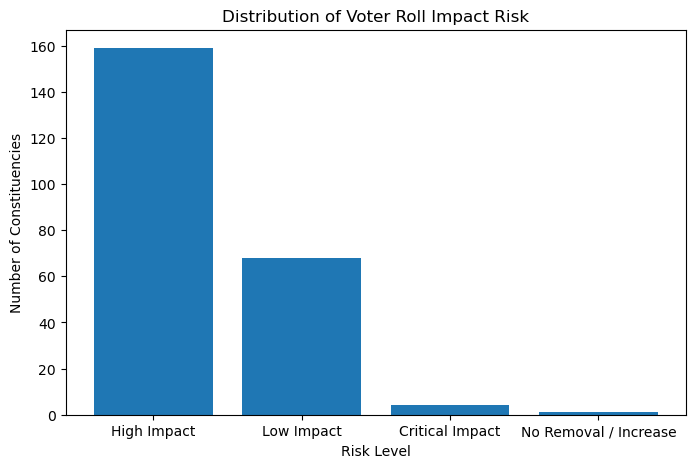

In [17]:
risk_counts = df_final_analysis["risk_level"].value_counts()

plt.figure(figsize=(8, 5))

plt.bar(
    risk_counts.index,
    risk_counts.values
)

plt.xlabel("Risk Level")
plt.ylabel("Number of Constituencies")
plt.title("Distribution of Voter Roll Impact Risk")

plt.show()

### Direct take away for the above chart

**What this chart shows**

- The chart shows how all **Assembly Constituencies** are grouped by **risk level** based on voter roll changes.
- Most constituencies fall under the **High Impact** category.

**What this means**

- **High Impact** means the number of voters removed is **greater than the margin that decided the 2021 election**.
- This shows that many seats are **numerically sensitive** to voter roll changes.
- Fewer seats fall under **Low Impact**, where roll changes are unlikely to matter.
- **Critical Impact** seats, though few, are the most sensitive.

### Winning majority context

- To form a government in Tamil Nadu, **118 out of 234 seats** are required.
- When many seats are high impact, even small changes across multiple constituencies can matter at the overall result level.

### Simple takeaway

> With a large number of constituencies classified as High Impact, voter roll accuracy becomes especially important in close contests, even though this analysis does not claim that results have changed.

## Conclusion

- This analysis shows that in several constituencies, voter roll removals are **higher than the victory margin from the 2021 election**, which means there **may be a chance for the election result to change** in those seats.  
- This does not confirm any outcome change, but it highlights that **accurate voter roll revision is especially important** in closely contested constituencies.
